In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, GRU, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Leer la data
train = pd.read_json('./train.json', lines=True)
test = pd.read_json('./test.json', lines=True)
sample = pd.read_csv('./sample_submission.csv')

In [6]:
if ~ train.isnull().values.any(): print('No missing values')
train.head().to_clipboard()

(2400, 19)
No missing values


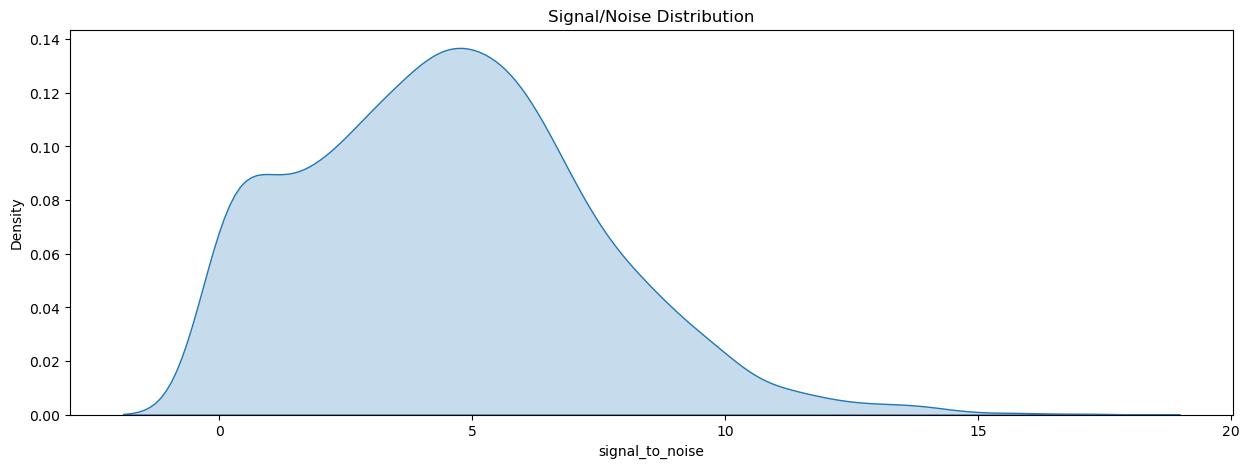

In [76]:
# Crear figura y subplot
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# Diagramar la distribucion señal a ruido 
sns.kdeplot(train['signal_to_noise'], fill=True, ax=ax)
ax.set_title('Signal/Noise Distribution')
# Mostrat diagrama
plt.show()

In [77]:
#Procesamiento
target_cols = ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C', 'deg_50C']

In [78]:
tok2int = {j:i for i, j in enumerate('().ACGUBEHIMSX')}


In [79]:
def preprocess_inputs(df, cols=['sequence', 'structure', 'predicted_loop_type']):
    tok2int = {j: i for i, j in enumerate('().ACGUBEHIMSX')}
    return np.transpose(
        np.array(
            df[cols]
            .applymap(lambda seq: [tok2int[j] for j in seq])
            .values
            .tolist()
        ),
        (0, 2, 1),
    )

In [80]:
# Personalizar las funciones para calculos
def rmse(y_actual, y_pred):
    mse = tf.keras.losses.mean_squared_error(y_actual, y_pred)
    return tf.sqrt(mse)

def mcrmse(y_actual, y_pred, num_scored=len(target_cols)):
    score = 0
    for i in range(num_scored):
        score += rmse(y_actual[:, :, i], y_pred[:, :, i]) / num_scored
    return score

In [81]:
train_inputs = preprocess_inputs(train)
train_labels = np.array(train[target_cols].values.tolist()).transpose((0, 2, 1))

In [82]:
#Modelo
len(tok2int)

14

In [83]:
def gru_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.GRU(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def lstm_layer(hidden_dim, dropout):
    return tf.keras.layers.Bidirectional(
                                tf.keras.layers.LSTM(hidden_dim,
                                dropout=dropout,
                                return_sequences=True,
                                kernel_initializer='orthogonal'))

def build_model(gru=False, lstm=False, seq_len=107, pred_len=68, dropout=0.4,
                embed_dim=100, hidden_dim=128, layers=3):
    
    inputs = tf.keras.layers.Input(shape=(seq_len, 3))

    embed = tf.keras.layers.Embedding(input_dim=len(tok2int), output_dim=embed_dim)(inputs)
    reshaped = tf.reshape(
        embed, shape=(-1, embed.shape[1],  embed.shape[2] * embed.shape[3]))
    
    hidden = tf.keras.layers.SpatialDropout1D(.2)(reshaped)
    
    if gru:
        for _ in range(layers):
            hidden = gru_layer(hidden_dim, dropout)(hidden)
        
    elif lstm:
        for _ in range(layers):
            hidden = lstm_layer(hidden_dim, dropout)(hidden)
    
    #Hacer predicciones solo en la primera parte de cada secuencia
    truncated = hidden[:, :pred_len]
    
    out = tf.keras.layers.Dense(5, activation='linear')(truncated)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    #Optimizadores
    adam = tf.optimizers.Adam()
    
    model.compile(optimizer=adam, loss=mcrmse)
    
    return model


In [102]:
#Entrenamiento Kfold
FOLDS = 10
EPOCHS = 50
REPEATS = 1
BATCH_SIZE = 64
VERBOSE = 2
SEED = 34

In [103]:
public_df = test.query("seq_length == 107").copy()
private_df = test.query("seq_length == 130").copy()

public_inputs = preprocess_inputs(public_df)
private_inputs = preprocess_inputs(private_df)

In [104]:
if tf.config.list_physical_devices('GPU') is not None:
    print('Entrenado en GPU')

Entrenado en GPU


In [105]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau()


In [106]:
gru_histories = []
gru_private_preds = np.zeros((private_df.shape[0], 130, 5))
gru_public_preds = np.zeros((public_df.shape[0], 107, 5))

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)

for f, (train_index, val_index) in enumerate(rskf.split(train_inputs, train['SN_filter'])):
    print(f"Fold {f}: train_index range = {train_index.min()}-{train_index.max()}, val_index range = {val_index.min()}-{val_index.max()}")

    sv_gru = tf.keras.callbacks.ModelCheckpoint(f'gru-{f}.h5')

    train_ = train_inputs[train_index]
    train_labs = train_labels[train_index]
    val_ = train_inputs[val_index]
    val_labs = train_labels[val_index]

    gru = build_model(gru=True)
    history = gru.fit(train_, train_labs, 
                      validation_data=(val_,val_labs),
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=[lr_callback,sv_gru],
                      verbose=VERBOSE)  

    gru_histories.append(history)

    # Cargar mejor modelo y predecir
    gru_short = build_model(gru=True, seq_len=107, pred_len=107)
    gru_short.load_weights(f'gru-{f}.h5')
    gru_public_pred = gru_short.predict(public_inputs) / FOLDS

    gru_long = build_model(gru=True, seq_len=130, pred_len=130)
    gru_long.load_weights(f'gru-{f}.h5')
    gru_private_pred = gru_long.predict(private_inputs) / FOLDS * REPEATS

    gru_public_preds += gru_public_pred
    gru_private_preds += gru_private_pred

    del gru_short, gru_long

Fold 0: train_index range = 0-2399, val_index range = 3-2381
Epoch 1/50
34/34 - 18s - loss: 0.6103 - val_loss: 0.4985 - lr: 0.0010 - 18s/epoch - 539ms/step
Epoch 2/50
34/34 - 14s - loss: 0.5500 - val_loss: 0.4766 - lr: 0.0010 - 14s/epoch - 414ms/step
Epoch 3/50
34/34 - 14s - loss: 0.5319 - val_loss: 0.4599 - lr: 0.0010 - 14s/epoch - 408ms/step
Epoch 4/50
34/34 - 14s - loss: 0.5169 - val_loss: 0.4446 - lr: 0.0010 - 14s/epoch - 414ms/step
Epoch 5/50
34/34 - 15s - loss: 0.5058 - val_loss: 0.4352 - lr: 0.0010 - 15s/epoch - 435ms/step
Epoch 6/50
34/34 - 15s - loss: 0.4993 - val_loss: 0.4284 - lr: 0.0010 - 15s/epoch - 429ms/step
Epoch 7/50
34/34 - 14s - loss: 0.4932 - val_loss: 0.4234 - lr: 0.0010 - 14s/epoch - 408ms/step
Epoch 8/50
34/34 - 14s - loss: 0.4881 - val_loss: 0.4169 - lr: 0.0010 - 14s/epoch - 404ms/step
Epoch 9/50
34/34 - 14s - loss: 0.4822 - val_loss: 0.4118 - lr: 0.0010 - 14s/epoch - 404ms/step
Epoch 10/50
34/34 - 14s - loss: 0.4773 - val_loss: 0.4065 - lr: 0.0010 - 14s/epoch -

34/34 - 14s - loss: 0.3948 - val_loss: 0.4442 - lr: 0.0010 - 14s/epoch - 418ms/step
Epoch 35/50
34/34 - 14s - loss: 0.3939 - val_loss: 0.4433 - lr: 0.0010 - 14s/epoch - 414ms/step
Epoch 36/50
34/34 - 14s - loss: 0.3926 - val_loss: 0.4441 - lr: 0.0010 - 14s/epoch - 408ms/step
Epoch 37/50
34/34 - 14s - loss: 0.3907 - val_loss: 0.4423 - lr: 0.0010 - 14s/epoch - 409ms/step
Epoch 38/50
34/34 - 14s - loss: 0.3908 - val_loss: 0.4410 - lr: 0.0010 - 14s/epoch - 413ms/step
Epoch 39/50
34/34 - 14s - loss: 0.3884 - val_loss: 0.4420 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 40/50
34/34 - 14s - loss: 0.3872 - val_loss: 0.4400 - lr: 0.0010 - 14s/epoch - 416ms/step
Epoch 41/50
34/34 - 14s - loss: 0.3860 - val_loss: 0.4398 - lr: 0.0010 - 14s/epoch - 415ms/step
Epoch 42/50
34/34 - 14s - loss: 0.3851 - val_loss: 0.4398 - lr: 0.0010 - 14s/epoch - 410ms/step
Epoch 43/50
34/34 - 14s - loss: 0.3845 - val_loss: 0.4385 - lr: 0.0010 - 14s/epoch - 407ms/step
Epoch 44/50
34/34 - 14s - loss: 0.3835 - val_loss: 0

34/34 - 14s - loss: 0.4448 - val_loss: 0.4529 - lr: 0.0010 - 14s/epoch - 411ms/step
Epoch 17/50
34/34 - 14s - loss: 0.4399 - val_loss: 0.4482 - lr: 0.0010 - 14s/epoch - 413ms/step
Epoch 18/50
34/34 - 14s - loss: 0.4369 - val_loss: 0.4483 - lr: 0.0010 - 14s/epoch - 417ms/step
Epoch 19/50
34/34 - 14s - loss: 0.4328 - val_loss: 0.4413 - lr: 0.0010 - 14s/epoch - 409ms/step
Epoch 20/50
34/34 - 14s - loss: 0.4277 - val_loss: 0.4404 - lr: 0.0010 - 14s/epoch - 411ms/step
Epoch 21/50
34/34 - 14s - loss: 0.4252 - val_loss: 0.4370 - lr: 0.0010 - 14s/epoch - 409ms/step
Epoch 22/50
34/34 - 14s - loss: 0.4224 - val_loss: 0.4397 - lr: 0.0010 - 14s/epoch - 410ms/step
Epoch 23/50
34/34 - 14s - loss: 0.4197 - val_loss: 0.4356 - lr: 0.0010 - 14s/epoch - 413ms/step
Epoch 24/50
34/34 - 14s - loss: 0.4167 - val_loss: 0.4361 - lr: 0.0010 - 14s/epoch - 408ms/step
Epoch 25/50
34/34 - 14s - loss: 0.4133 - val_loss: 0.4272 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 26/50
34/34 - 14s - loss: 0.4112 - val_loss: 0

Epoch 50/50
34/34 - 14s - loss: 0.3795 - val_loss: 0.4024 - lr: 0.0010 - 14s/epoch - 417ms/step
94/94 [==============================] - 10s 98ms/step
Fold 5: train_index range = 0-2399, val_index range = 15-2398
Epoch 1/50
34/34 - 17s - loss: 0.6113 - val_loss: 0.5214 - lr: 0.0010 - 17s/epoch - 493ms/step
Epoch 2/50
34/34 - 13s - loss: 0.5468 - val_loss: 0.4953 - lr: 0.0010 - 13s/epoch - 397ms/step
Epoch 3/50
34/34 - 14s - loss: 0.5275 - val_loss: 0.4752 - lr: 0.0010 - 14s/epoch - 402ms/step
Epoch 4/50
34/34 - 14s - loss: 0.5128 - val_loss: 0.4632 - lr: 0.0010 - 14s/epoch - 410ms/step
Epoch 5/50
34/34 - 14s - loss: 0.5027 - val_loss: 0.4552 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 6/50
34/34 - 14s - loss: 0.4963 - val_loss: 0.4506 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 7/50
34/34 - 14s - loss: 0.4896 - val_loss: 0.4452 - lr: 0.0010 - 14s/epoch - 410ms/step
Epoch 8/50
34/34 - 14s - loss: 0.4843 - val_loss: 0.4360 - lr: 0.0010 - 14s/epoch - 415ms/step
Epoch 9/50
34/34 - 14s - lo

Epoch 32/50
34/34 - 14s - loss: 0.4023 - val_loss: 0.4029 - lr: 0.0010 - 14s/epoch - 426ms/step
Epoch 33/50
34/34 - 14s - loss: 0.4017 - val_loss: 0.4054 - lr: 0.0010 - 14s/epoch - 417ms/step
Epoch 34/50
34/34 - 20s - loss: 0.4003 - val_loss: 0.4053 - lr: 0.0010 - 20s/epoch - 596ms/step
Epoch 35/50
34/34 - 14s - loss: 0.3989 - val_loss: 0.4003 - lr: 0.0010 - 14s/epoch - 413ms/step
Epoch 36/50
34/34 - 14s - loss: 0.3967 - val_loss: 0.4030 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 37/50
34/34 - 20s - loss: 0.3967 - val_loss: 0.4016 - lr: 0.0010 - 20s/epoch - 588ms/step
Epoch 38/50
34/34 - 14s - loss: 0.3951 - val_loss: 0.4002 - lr: 0.0010 - 14s/epoch - 410ms/step
Epoch 39/50
34/34 - 14s - loss: 0.3930 - val_loss: 0.3995 - lr: 0.0010 - 14s/epoch - 413ms/step
Epoch 40/50
34/34 - 940s - loss: 0.3924 - val_loss: 0.3968 - lr: 0.0010 - 940s/epoch - 28s/step
Epoch 41/50
34/34 - 15s - loss: 0.3916 - val_loss: 0.3998 - lr: 0.0010 - 15s/epoch - 444ms/step
Epoch 42/50
34/34 - 15s - loss: 0.3897 -

34/34 - 14s - loss: 0.4531 - val_loss: 0.4508 - lr: 0.0010 - 14s/epoch - 422ms/step
Epoch 15/50
34/34 - 14s - loss: 0.4479 - val_loss: 0.4441 - lr: 0.0010 - 14s/epoch - 424ms/step
Epoch 16/50
34/34 - 15s - loss: 0.4431 - val_loss: 0.4393 - lr: 0.0010 - 15s/epoch - 435ms/step
Epoch 17/50
34/34 - 14s - loss: 0.4397 - val_loss: 0.4370 - lr: 0.0010 - 14s/epoch - 423ms/step
Epoch 18/50
34/34 - 14s - loss: 0.4352 - val_loss: 0.4307 - lr: 0.0010 - 14s/epoch - 422ms/step
Epoch 19/50
34/34 - 14s - loss: 0.4317 - val_loss: 0.4295 - lr: 0.0010 - 14s/epoch - 413ms/step
Epoch 20/50
34/34 - 14s - loss: 0.4281 - val_loss: 0.4259 - lr: 0.0010 - 14s/epoch - 415ms/step
Epoch 21/50
34/34 - 14s - loss: 0.4259 - val_loss: 0.4216 - lr: 0.0010 - 14s/epoch - 416ms/step
Epoch 22/50
34/34 - 14s - loss: 0.4222 - val_loss: 0.4190 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 23/50
34/34 - 14s - loss: 0.4202 - val_loss: 0.4170 - lr: 0.0010 - 14s/epoch - 412ms/step
Epoch 24/50
34/34 - 14s - loss: 0.4170 - val_loss: 0

Epoch 48/50
34/34 - 14s - loss: 0.3812 - val_loss: 0.4264 - lr: 0.0010 - 14s/epoch - 424ms/step
Epoch 49/50
34/34 - 14s - loss: 0.3802 - val_loss: 0.4237 - lr: 0.0010 - 14s/epoch - 422ms/step
Epoch 50/50
34/34 - 14s - loss: 0.3800 - val_loss: 0.4246 - lr: 0.0010 - 14s/epoch - 420ms/step
94/94 [==============================] - 10s 100ms/step


In [107]:
print(f" El Valor MCRMSE de GRU es: {np.mean([min(history.history['val_loss']) for history in gru_histories])}")

 El Valor MCRMSE de GRU es: 0.39300484359264376


In [108]:
#LSTM
lstm_histories = []
lstm_private_preds = np.zeros((private_df.shape[0], 130, 5))
lstm_public_preds = np.zeros((public_df.shape[0], 107, 5))

rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)

for f, (train_index, val_index) in enumerate(rskf.split(train_inputs, train['SN_filter'])):

    sv_gru = tf.keras.callbacks.ModelCheckpoint(f'lstm-{f}.h5')

    train_ = train_inputs[train_index]
    train_labs = train_labels[train_index]
    val_ = train_inputs[val_index]
    val_labs = train_labels[val_index]

    lstm = build_model(lstm=True)
    history = lstm.fit(
                        train_, train_labs, 
                        validation_data=(val_,val_labs),
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=[lr_callback,sv_gru],
                        verbose = VERBOSE)  

    lstm_histories.append(history)

    #Cargar mejor modelo y predecir
    lstm_short = build_model(lstm=True, seq_len=107, pred_len=107)
    lstm_short.load_weights(f'lstm-{f}.h5')
    lstm_public_pred = lstm_short.predict(public_inputs) / FOLDS

    lstm_long = build_model(lstm=True, seq_len=130, pred_len=130)
    lstm_long.load_weights(f'lstm-{f}.h5')
    lstm_private_pred = lstm_long.predict(private_inputs) / FOLDS * REPEATS

    lstm_public_preds += lstm_public_pred
    lstm_private_preds += lstm_private_pred

    del lstm_short, lstm_long

Epoch 1/50
34/34 - 18s - loss: 0.6345 - val_loss: 0.5227 - lr: 0.0010 - 18s/epoch - 544ms/step
Epoch 2/50
34/34 - 15s - loss: 0.5616 - val_loss: 0.4850 - lr: 0.0010 - 15s/epoch - 447ms/step
Epoch 3/50
34/34 - 16s - loss: 0.5407 - val_loss: 0.4708 - lr: 0.0010 - 16s/epoch - 460ms/step
Epoch 4/50
34/34 - 16s - loss: 0.5291 - val_loss: 0.4578 - lr: 0.0010 - 16s/epoch - 463ms/step
Epoch 5/50
34/34 - 16s - loss: 0.5150 - val_loss: 0.4465 - lr: 0.0010 - 16s/epoch - 463ms/step
Epoch 6/50
34/34 - 16s - loss: 0.5052 - val_loss: 0.4349 - lr: 0.0010 - 16s/epoch - 460ms/step
Epoch 7/50
34/34 - 16s - loss: 0.4990 - val_loss: 0.4274 - lr: 0.0010 - 16s/epoch - 462ms/step
Epoch 8/50
34/34 - 16s - loss: 0.4925 - val_loss: 0.4217 - lr: 0.0010 - 16s/epoch - 463ms/step
Epoch 9/50
34/34 - 16s - loss: 0.4847 - val_loss: 0.4120 - lr: 0.0010 - 16s/epoch - 463ms/step
Epoch 10/50
34/34 - 16s - loss: 0.4792 - val_loss: 0.4088 - lr: 0.0010 - 16s/epoch - 461ms/step
Epoch 11/50
34/34 - 16s - loss: 0.4744 - val_loss

Epoch 36/50
34/34 - 16s - loss: 0.3862 - val_loss: 0.4409 - lr: 0.0010 - 16s/epoch - 469ms/step
Epoch 37/50
34/34 - 16s - loss: 0.3847 - val_loss: 0.4409 - lr: 0.0010 - 16s/epoch - 477ms/step
Epoch 38/50
34/34 - 16s - loss: 0.3829 - val_loss: 0.4385 - lr: 0.0010 - 16s/epoch - 468ms/step
Epoch 39/50
34/34 - 16s - loss: 0.3817 - val_loss: 0.4398 - lr: 0.0010 - 16s/epoch - 471ms/step
Epoch 40/50
34/34 - 16s - loss: 0.3801 - val_loss: 0.4375 - lr: 0.0010 - 16s/epoch - 468ms/step
Epoch 41/50
34/34 - 16s - loss: 0.3783 - val_loss: 0.4384 - lr: 0.0010 - 16s/epoch - 472ms/step
Epoch 42/50
34/34 - 16s - loss: 0.3765 - val_loss: 0.4375 - lr: 0.0010 - 16s/epoch - 474ms/step
Epoch 43/50
34/34 - 16s - loss: 0.3757 - val_loss: 0.4396 - lr: 0.0010 - 16s/epoch - 483ms/step
Epoch 44/50
34/34 - 16s - loss: 0.3744 - val_loss: 0.4361 - lr: 0.0010 - 16s/epoch - 474ms/step
Epoch 45/50
34/34 - 16s - loss: 0.3729 - val_loss: 0.4338 - lr: 0.0010 - 16s/epoch - 470ms/step
Epoch 46/50
34/34 - 16s - loss: 0.3722 -

Epoch 20/50
34/34 - 16s - loss: 0.4278 - val_loss: 0.4429 - lr: 0.0010 - 16s/epoch - 467ms/step
Epoch 21/50
34/34 - 16s - loss: 0.4246 - val_loss: 0.4384 - lr: 0.0010 - 16s/epoch - 465ms/step
Epoch 22/50
34/34 - 937s - loss: 0.4226 - val_loss: 0.4391 - lr: 0.0010 - 937s/epoch - 28s/step
Epoch 23/50
34/34 - 17s - loss: 0.4187 - val_loss: 0.4339 - lr: 0.0010 - 17s/epoch - 512ms/step
Epoch 24/50
34/34 - 17s - loss: 0.4148 - val_loss: 0.4331 - lr: 0.0010 - 17s/epoch - 502ms/step
Epoch 25/50
34/34 - 17s - loss: 0.4125 - val_loss: 0.4308 - lr: 0.0010 - 17s/epoch - 490ms/step
Epoch 26/50
34/34 - 16s - loss: 0.4095 - val_loss: 0.4313 - lr: 0.0010 - 16s/epoch - 473ms/step
Epoch 27/50
34/34 - 16s - loss: 0.4071 - val_loss: 0.4298 - lr: 0.0010 - 16s/epoch - 471ms/step
Epoch 28/50
34/34 - 16s - loss: 0.4050 - val_loss: 0.4262 - lr: 0.0010 - 16s/epoch - 468ms/step
Epoch 29/50
34/34 - 16s - loss: 0.4022 - val_loss: 0.4239 - lr: 0.0010 - 16s/epoch - 471ms/step
Epoch 30/50
34/34 - 16s - loss: 0.3999 -

Epoch 4/50
34/34 - 16s - loss: 0.5264 - val_loss: 0.4780 - lr: 0.0010 - 16s/epoch - 480ms/step
Epoch 5/50
34/34 - 16s - loss: 0.5121 - val_loss: 0.4657 - lr: 0.0010 - 16s/epoch - 479ms/step
Epoch 6/50
34/34 - 16s - loss: 0.5022 - val_loss: 0.4556 - lr: 0.0010 - 16s/epoch - 473ms/step
Epoch 7/50
34/34 - 16s - loss: 0.4953 - val_loss: 0.4521 - lr: 0.0010 - 16s/epoch - 474ms/step
Epoch 8/50
34/34 - 16s - loss: 0.4889 - val_loss: 0.4439 - lr: 0.0010 - 16s/epoch - 472ms/step
Epoch 9/50
34/34 - 16s - loss: 0.4839 - val_loss: 0.4420 - lr: 0.0010 - 16s/epoch - 475ms/step
Epoch 10/50
34/34 - 17s - loss: 0.4796 - val_loss: 0.4344 - lr: 0.0010 - 17s/epoch - 486ms/step
Epoch 11/50
34/34 - 16s - loss: 0.4735 - val_loss: 0.4308 - lr: 0.0010 - 16s/epoch - 469ms/step
Epoch 12/50
34/34 - 16s - loss: 0.4700 - val_loss: 0.4252 - lr: 0.0010 - 16s/epoch - 473ms/step
Epoch 13/50
34/34 - 16s - loss: 0.4651 - val_loss: 0.4211 - lr: 0.0010 - 16s/epoch - 479ms/step
Epoch 14/50
34/34 - 16s - loss: 0.4595 - val_l

Epoch 39/50
34/34 - 955s - loss: 0.3859 - val_loss: 0.3984 - lr: 0.0010 - 955s/epoch - 28s/step
Epoch 40/50
34/34 - 16s - loss: 0.3851 - val_loss: 0.4020 - lr: 0.0010 - 16s/epoch - 462ms/step
Epoch 41/50
34/34 - 16s - loss: 0.3837 - val_loss: 0.4001 - lr: 0.0010 - 16s/epoch - 465ms/step
Epoch 42/50
34/34 - 942s - loss: 0.3830 - val_loss: 0.3985 - lr: 0.0010 - 942s/epoch - 28s/step
Epoch 43/50
34/34 - 16s - loss: 0.3808 - val_loss: 0.3968 - lr: 0.0010 - 16s/epoch - 465ms/step
Epoch 44/50
34/34 - 16s - loss: 0.3786 - val_loss: 0.3972 - lr: 0.0010 - 16s/epoch - 457ms/step
Epoch 45/50
34/34 - 15s - loss: 0.3773 - val_loss: 0.3960 - lr: 0.0010 - 15s/epoch - 454ms/step
Epoch 46/50
34/34 - 955s - loss: 0.3762 - val_loss: 0.3955 - lr: 0.0010 - 955s/epoch - 28s/step
Epoch 47/50
34/34 - 16s - loss: 0.3760 - val_loss: 0.3950 - lr: 0.0010 - 16s/epoch - 461ms/step
Epoch 48/50
34/34 - 16s - loss: 0.3740 - val_loss: 0.3948 - lr: 0.0010 - 16s/epoch - 457ms/step
Epoch 49/50
34/34 - 942s - loss: 0.3729 

Epoch 23/50
34/34 - 16s - loss: 0.4196 - val_loss: 0.4185 - lr: 0.0010 - 16s/epoch - 462ms/step
Epoch 24/50
34/34 - 16s - loss: 0.4180 - val_loss: 0.4180 - lr: 0.0010 - 16s/epoch - 461ms/step
Epoch 25/50
34/34 - 16s - loss: 0.4147 - val_loss: 0.4158 - lr: 0.0010 - 16s/epoch - 457ms/step
Epoch 26/50
34/34 - 924s - loss: 0.4116 - val_loss: 0.4165 - lr: 0.0010 - 924s/epoch - 27s/step
Epoch 27/50
34/34 - 16s - loss: 0.4099 - val_loss: 0.4133 - lr: 0.0010 - 16s/epoch - 466ms/step
Epoch 28/50
34/34 - 16s - loss: 0.4064 - val_loss: 0.4119 - lr: 0.0010 - 16s/epoch - 465ms/step
Epoch 29/50
34/34 - 921s - loss: 0.4057 - val_loss: 0.4098 - lr: 0.0010 - 921s/epoch - 27s/step
Epoch 30/50
34/34 - 16s - loss: 0.4034 - val_loss: 0.4085 - lr: 0.0010 - 16s/epoch - 467ms/step
Epoch 31/50
34/34 - 16s - loss: 0.4019 - val_loss: 0.4098 - lr: 0.0010 - 16s/epoch - 466ms/step
Epoch 32/50
34/34 - 942s - loss: 0.4002 - val_loss: 0.4071 - lr: 0.0010 - 942s/epoch - 28s/step
Epoch 33/50
34/34 - 16s - loss: 0.3991 -

In [109]:
print(f"  El Valor MCRMSE de LSTM es: {np.mean([min(history.history['val_loss']) for history in lstm_histories])}")


  El Valor MCRMSE de LSTM es: 0.3923438131809235


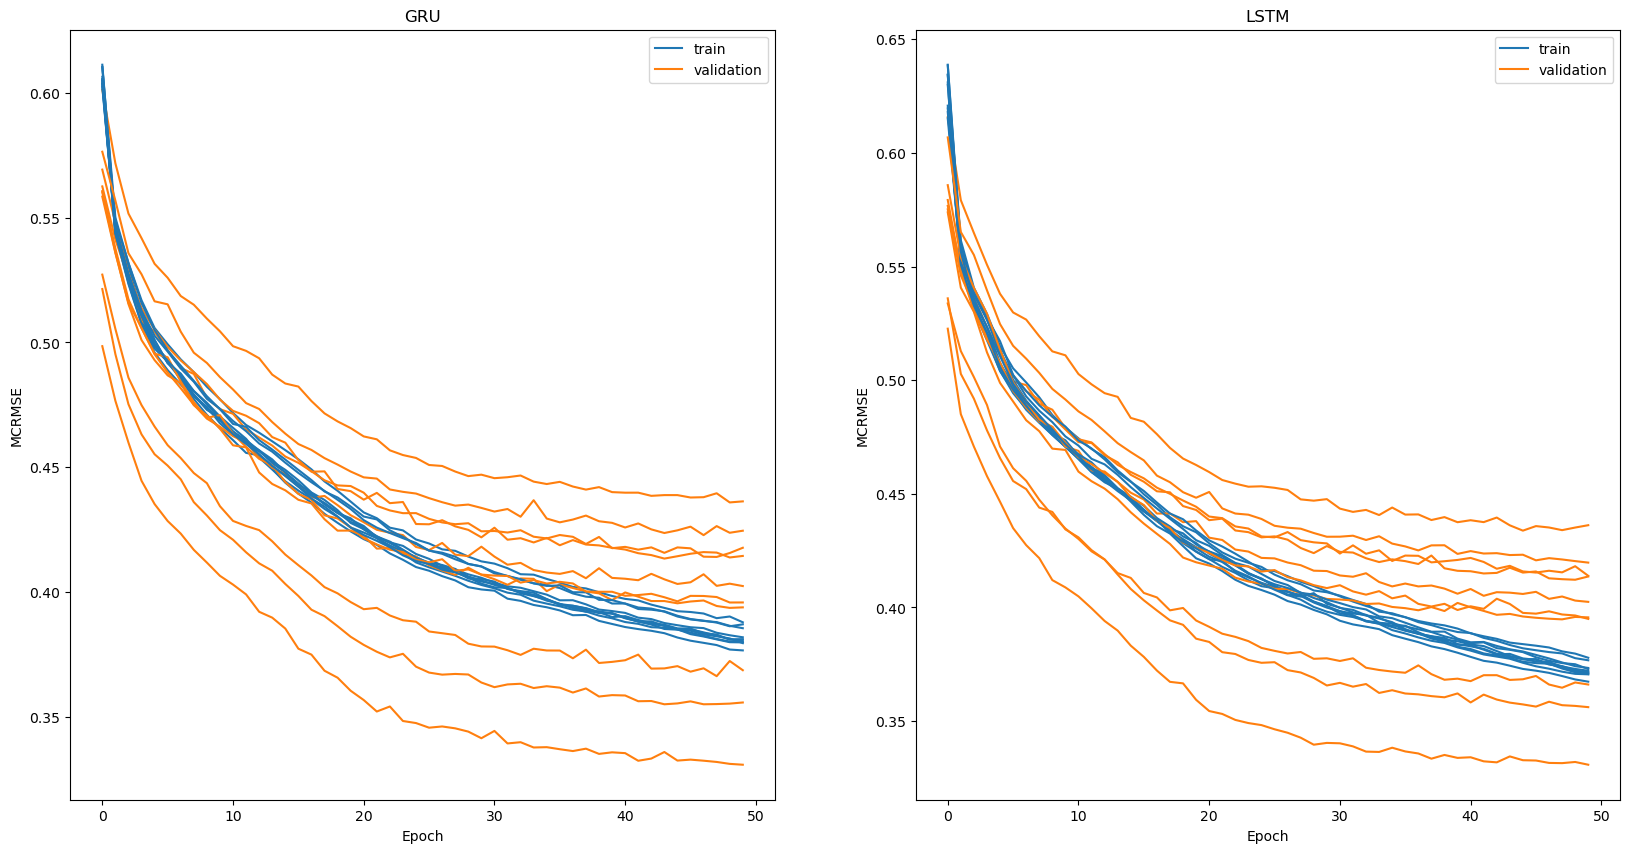

In [110]:
#Graficas de los resultados
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

for history in gru_histories:
    ax[0].plot(history.history['loss'], color='C0')
    ax[0].plot(history.history['val_loss'], color='C1')
for history in lstm_histories:
    ax[1].plot(history.history['loss'], color='C0')
    ax[1].plot(history.history['val_loss'], color='C1')

ax[0].set_title('GRU')
ax[1].set_title('LSTM')

ax[0].legend(['train', 'validation'], loc = 'upper right')
ax[1].legend(['train', 'validation'], loc = 'upper right')

ax[0].set_ylabel('MCRMSE')
ax[0].set_xlabel('Epoch')
ax[1].set_ylabel('MCRMSE')
ax[1].set_xlabel('Epoch');